In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
f = np.genfromtxt('noisy_signal.csv', delimiter=',')
f = f.reshape((-1,1))
n_x = len(f)
n_y = n_x - 1
print(n_x, n_y)

1000 999


In [3]:
I = np.eye(n_y)
zcol = np.zeros((n_y,1))
I1 = np.hstack ([I, zcol])
I2 = np.hstack([zcol, -I])
L = (I1 + I2)*999
print(f"shape of L = {L.shape}")
print(L)

shape of L = (999, 1000)
[[ 999. -999.    0. ...    0.    0.    0.]
 [   0.  999. -999. ...    0.    0.    0.]
 [   0.    0.  999. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ... -999.    0.    0.]
 [   0.    0.    0. ...  999. -999.    0.]
 [   0.    0.    0. ...    0.  999. -999.]]


In [4]:
lambda_ = 5 * 10**(-4)
gamma = 10**3
omega = 75
u_tol = 10**(-4)
x_tol = 10**(-5)

omega_bar = np.vstack([np.zeros((n_x,1)), omega*np.ones((n_y,1))])
L_bar = np.hstack([-L, np.eye(n_y)])
A_bar = np.hstack([np.eye(n_x), np.zeros((n_x, n_y))])

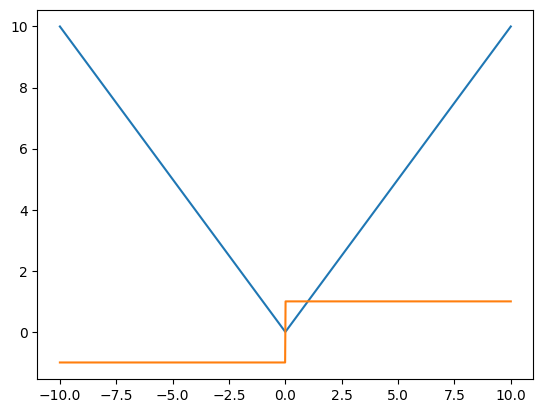

In [5]:
def h(gamma, t):
    abs_t = np.abs(t)
    return np.where(abs_t <= 1/gamma, gamma * t**2 / 2, abs_t - 1 / (2 * gamma))

def hd(gamma, t):
    abs_t = np.abs(t)
    return np.where(abs_t <= 1/gamma, gamma * t, np.sign(t))

t_range = np.linspace(-10, 10, 1000)
h_r = h(gamma, t_range)
hd_r = hd(gamma, t_range)
plt.plot(t_range, h_r)
plt.plot(t_range, hd_r)
plt.show()

In [6]:
def approx_1_norm(gamma, omega_bar, u):
    u_flat = u.flatten()
    h_values = h(gamma, u_flat)
    return np.dot(omega_bar.flatten(), h_values)

def approx_1_norm_grad(gamma, omega_bar, u):
    u_flat = u.flatten()
    hd_values = hd(gamma, u_flat)
    return (omega_bar.flatten() * hd_values).reshape(-1, 1)

def u_cost(A_bar, u, f, gamma, L_bar, lambda_, z):
    t_1 = 1/2 * np.linalg.norm(A_bar@u -f)**2 + lambda_/2 * np.linalg.norm(L_bar@u - z)**2
    return t_1 + approx_1_norm(gamma, omega_bar, u)

def u_cost_grad(A_bar, u, f, gamma, L_bar, lambda_, z):
    t_1 = A_bar.T @ (A_bar@u - f) + lambda_ * L_bar.T @ (L_bar@u - z)
    t_2 = approx_1_norm_grad(gamma, omega_bar, u)
    return t_1 + t_2

In [7]:
s = 1
alpha = 1e-4
beta = 0.5

x_start = f
y_start = L@x_start
z_start = np.ones((n_y,1))
u_start = np.vstack([x_start, y_start])

x = x_start.copy()
y = y_start.copy()
z = z_start.copy()
u = u_start.copy()

step_errors = []

In [8]:
inner_max_iter = 500
outer_max_iter = int(1e2)
print_inner = True
print_outer = True

for outer_iteration in range(1, outer_max_iter+1):

    #Gradient descent
    for inner_iteration in range(1, inner_max_iter+1):
        #Backtracking
        t = s
        cost = u_cost(A_bar, u, f, gamma, L_bar, lambda_, z)
        cost_grad = u_cost_grad(A_bar, u, f, gamma, L_bar, lambda_, z)
        d = - cost_grad
        measure = alpha * t * (np.linalg.norm(cost_grad)**2)

        while True:
            u_new = u + t * d
            cost_new = u_cost(A_bar, u_new, f, gamma, L_bar, lambda_, z)
            if (cost - cost_new) >= measure:
                break
            else:
                t *= beta
                measure *= beta
        
        u_old = u
        u = u_new
        #Check criterion
        if np.linalg.norm(u - u_old)/np.linalg.norm(u) < u_tol:
            if print_inner == True:
                print(f"Gradient convergence reached at inner iteration {inner_iteration}")
            break
            



    #Update x
    x_old = x
    x = u[:n_x]

    #Update y
    y_old = y
    y = u[-n_y:]

    #Update z
    z += L@x - y

    #x criterion
    step_error = np.linalg.norm(x - x_old)/np.linalg.norm(x)
    step_errors.append(step_error)
    if step_error < x_tol:
        if print_outer == True:
            print(f"Convergence reached at outer iteration {outer_iteration}")
        break
    


Gradient convergence reached at inner iteration 294
Gradient convergence reached at inner iteration 1
Gradient convergence reached at inner iteration 1
Gradient convergence reached at inner iteration 1
Convergence reached at outer iteration 6


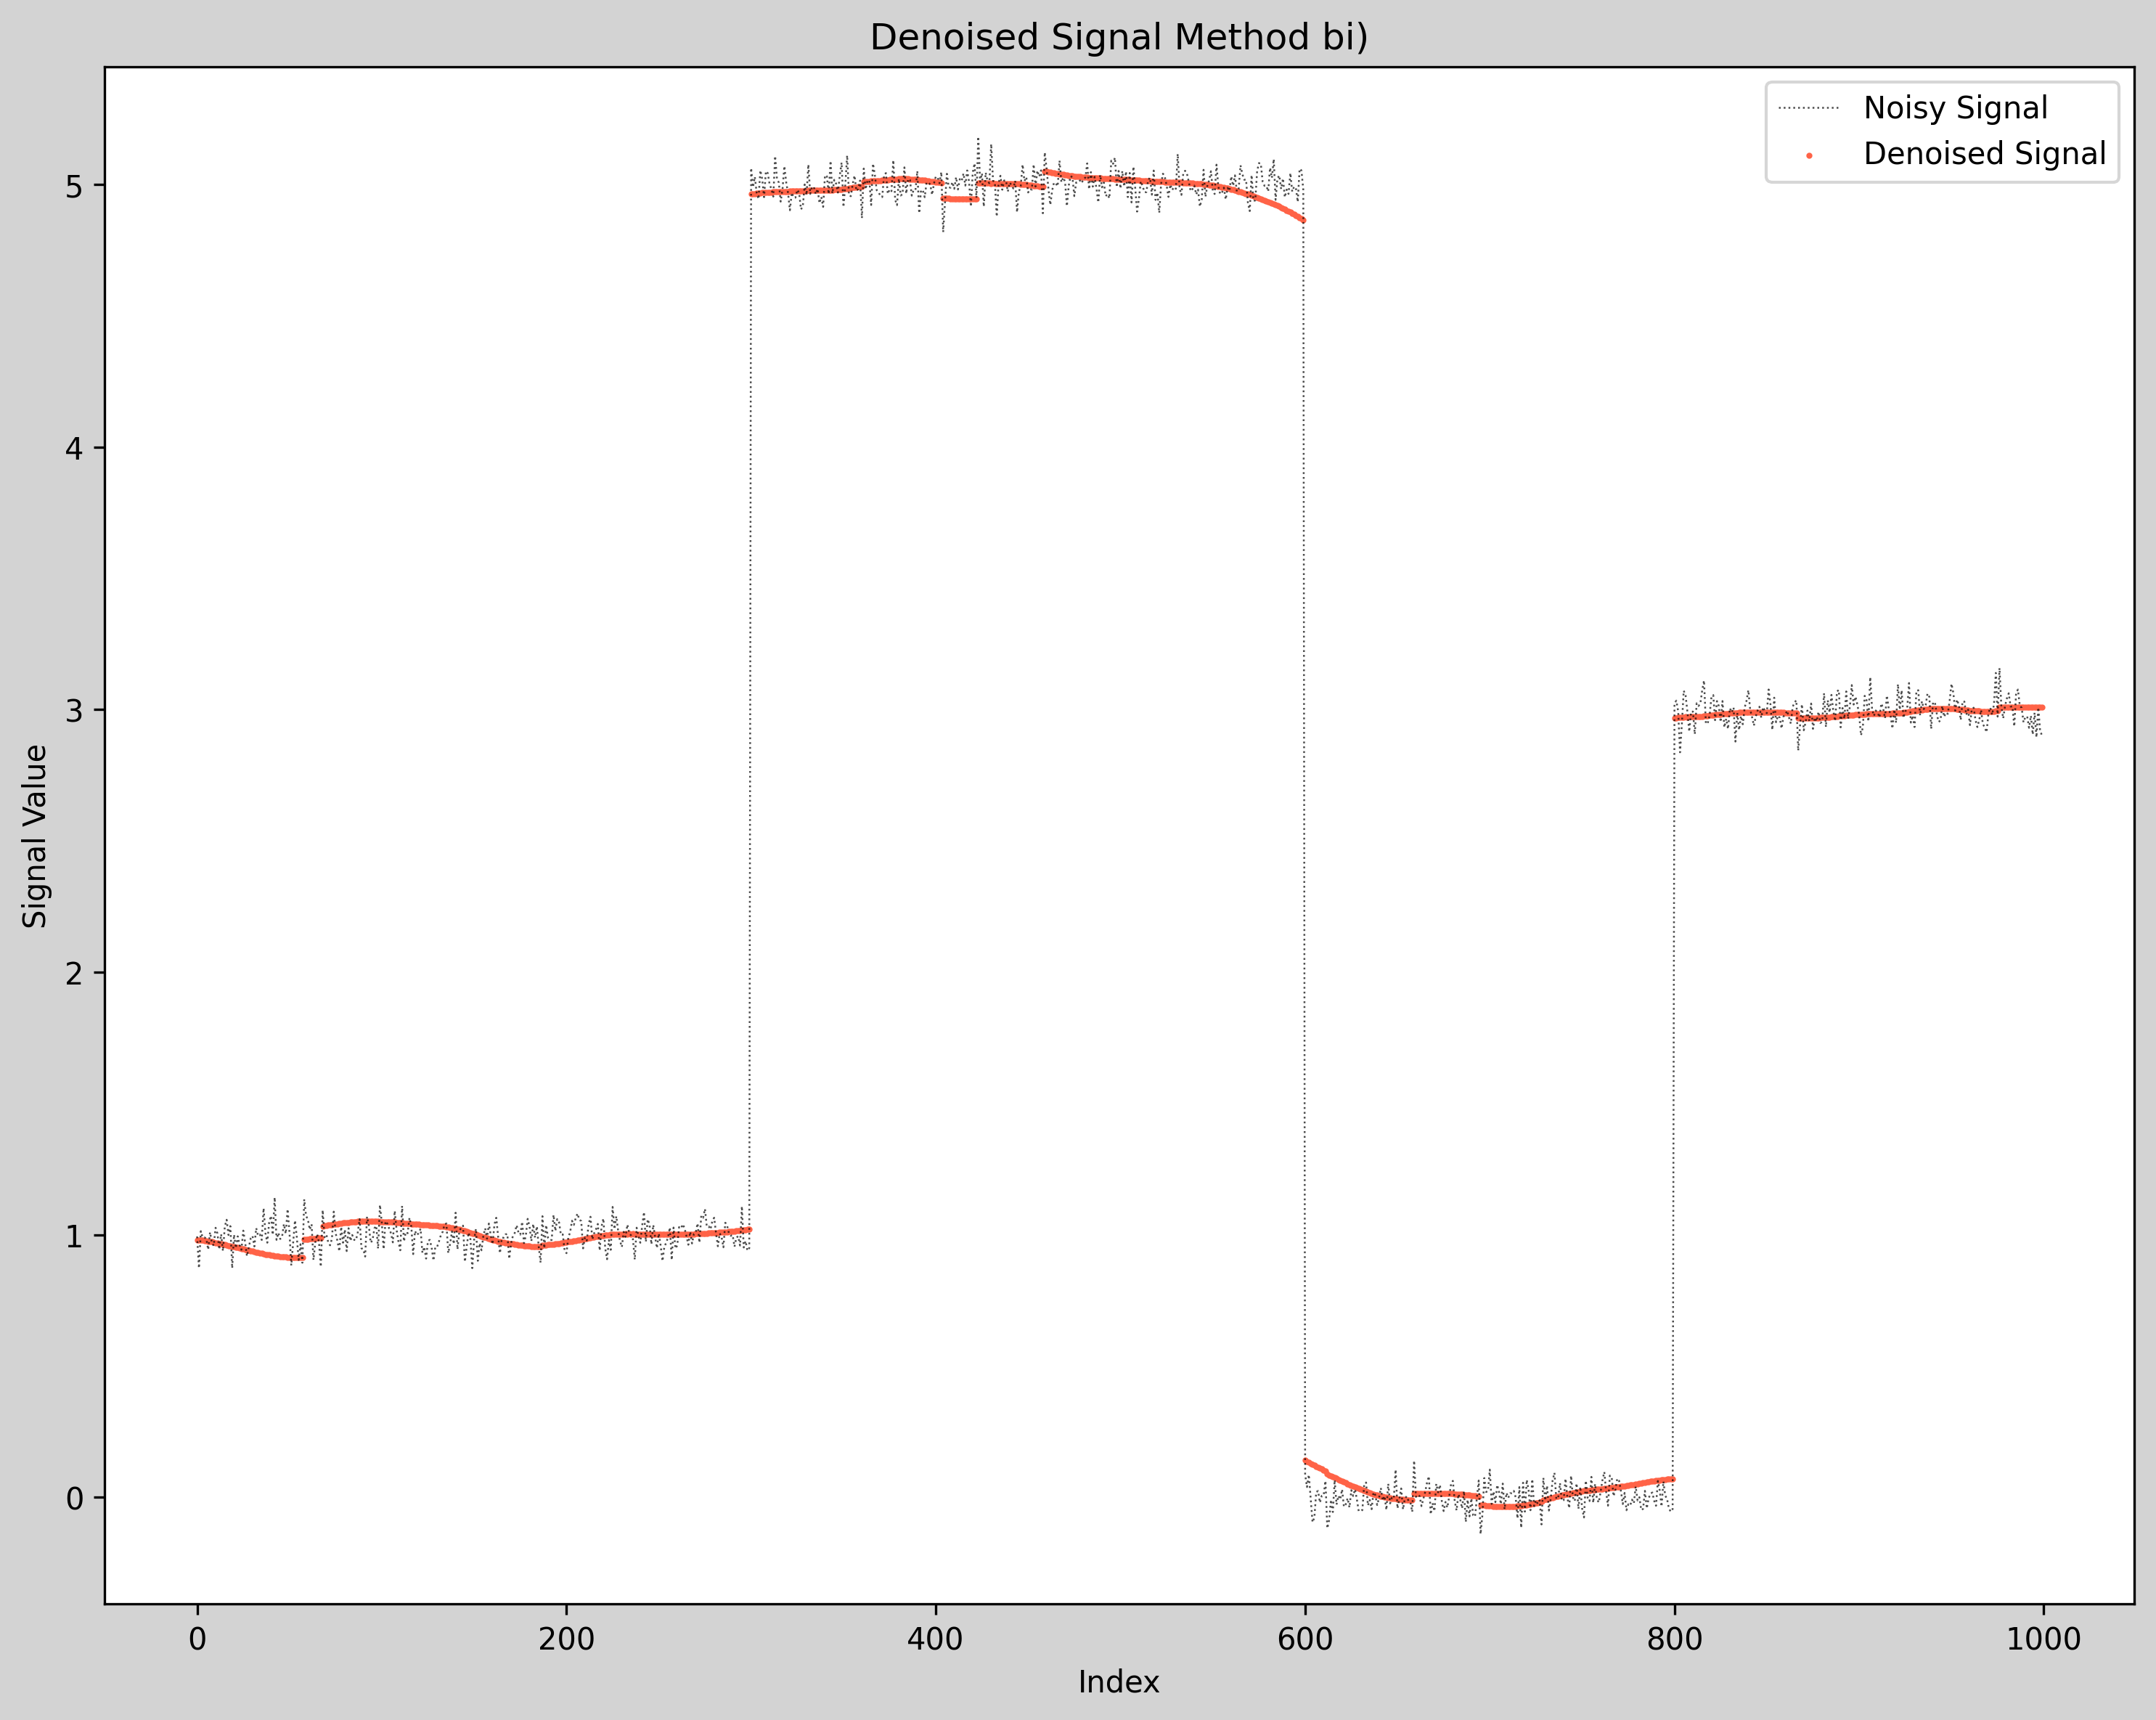

In [9]:
plt.figure(figsize=(10,8), dpi=300, facecolor='lightgray')
plt.title("Denoised Signal Method bi)")
plt.ylabel("Signal Value")
plt.xlabel("Index")
plt.plot(f[:], linestyle=':', lw=0.6, color='k', label='Noisy Signal', alpha=0.7)
plt.scatter(np.arange(len(x)), x, s=1, color='tomato', label = "Denoised Signal")
plt.tight_layout()
plt.legend()
plt.show()

In [10]:
s = 1
alpha = 1e-4
beta = 0.5

x_start = f
y_start = L@x_start
z_start = np.ones((n_y,1))
u_start = np.vstack([x_start, y_start])

x = x_start.copy()
y = y_start.copy()
z = z_start.copy()
u = u_start.copy()

step_errors = []

In [11]:
e = []
for outer_iteration in range(1, outer_max_iter+1):
    print(f"outer iteration: {outer_iteration}")
    
    iteration = 0
    # Gradient descent loop
    while True:
        iteration += 1
        
        # Compute gradient and direction
        u_grad = u_cost_grad(A_bar, u, f, gamma, L_bar, lambda_, z)
        d = -u_grad  # Descent direction
        # Backtracking line search
        t = 1
        initial_u_cost = u_cost(A_bar, u, f, gamma, L_bar, lambda_, z)
        measure = -alpha * t * np.dot(u_grad.T, d)
        
        while True:
            new_u = u + t * d
            new_u_cost = u_cost(A_bar, new_u, f, gamma, L_bar, lambda_, z)
            if new_u_cost <= initial_u_cost - measure:
                break
            t *= beta
            measure *= beta #= -alpha * t * np.dot(u_grad.T, d)

        # Update `u` and check for convergence
        u_new = u + t * d
        if np.linalg.norm(u_new - u) / np.linalg.norm(u) < u_tol:
            u = u_new
            print(f"gradient iteration: {iteration}")
            break
        u = u_new
        if iteration >= 500:
            break

    # Update x, y, and z and check for convergence
    x_old = x
    x = u[:n_x]
    y = u[-n_y:]
    z += (L @ x - y)
    error = np.linalg.norm(x - x_old) / np.linalg.norm(x)
    e.append(error)
    if error<x_tol:
        break

outer iteration: 1
outer iteration: 2
outer iteration: 3
gradient iteration: 294
outer iteration: 4
gradient iteration: 1
outer iteration: 5
gradient iteration: 1
outer iteration: 6
gradient iteration: 1


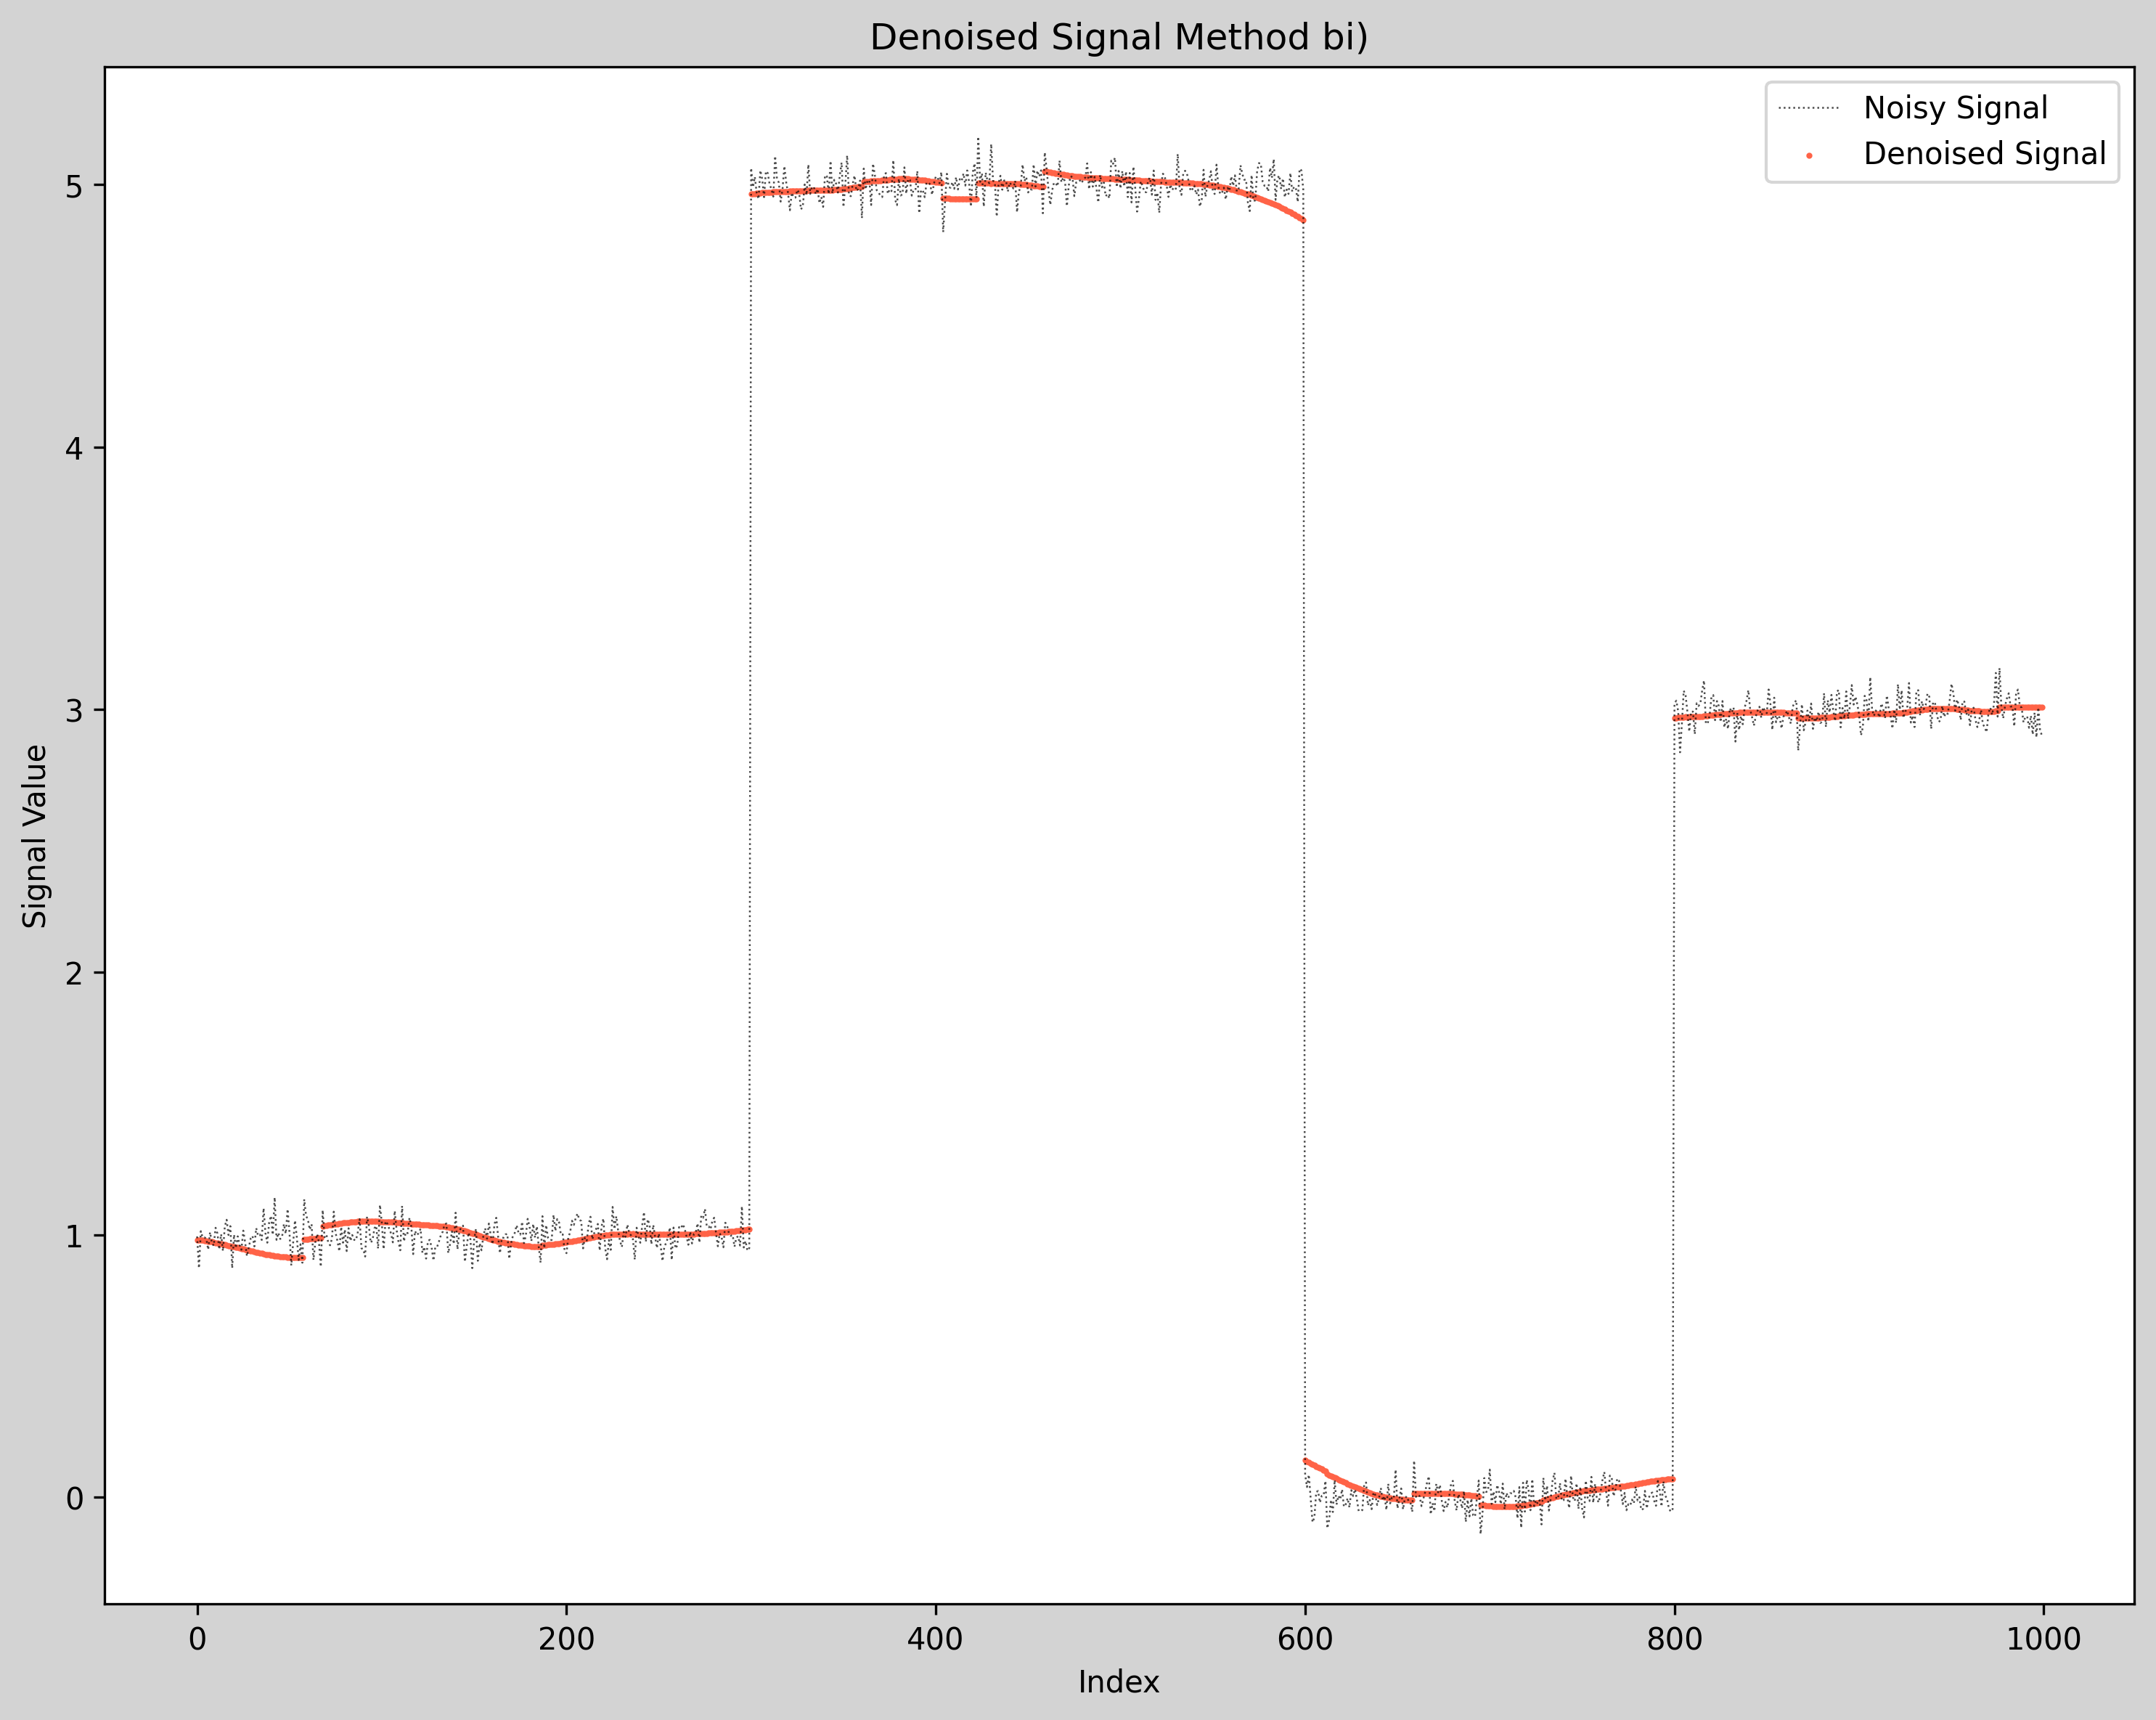

In [14]:
plt.figure(figsize=(10,8), dpi=300, facecolor='lightgray')
plt.title("Denoised Signal Method bi)")
plt.ylabel("Signal Value")
plt.xlabel("Index")
plt.plot(f[:], linestyle=':', lw=0.6, color='k', label='Noisy Signal', alpha=0.7)
plt.scatter(np.arange(len(x)), x, s=1, color='tomato', label = "Denoised Signal")
plt.tight_layout()
plt.legend()
plt.savefig("bi_alt.png")
plt.show()